(5, 5) 5


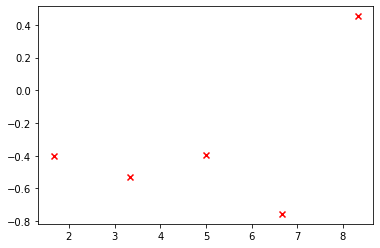

In [164]:
import numpy as np
from matplotlib import pyplot as plt

def ou_cov(sigma, gamma, t, t_):
    
    coeff = 0.5 * sigma ** 2 / gamma
    exp = np.exp(- gamma * np.abs(t[..., :, None] - t_[..., None, :]))
    
    return coeff * exp

t0 = 0.
t1 = 10.

sigma = 1.
gamma = 2.
r = 1e-1

num_train_pts = 5
grid_size = 10000
interval_size = int(grid_size / (num_train_pts + 1) - 1e-6)

np.random.seed(1)

t_grid = np.linspace(t0, t1, grid_size)
t_train = t_grid[::interval_size][1:-1]

x_mean = np.zeros((num_train_pts,))
x_cov = ou_cov(sigma=sigma, gamma=gamma, t=t_train, t_=t_train)
print(x_cov.shape, num_train_pts)
x_cov = x_cov + r ** 2 * np.eye(num_train_pts)

x_train = np.random.multivariate_normal(mean=x_mean, cov=x_cov)

plt.scatter(t_train, x_train, marker='x', color='red', zorder=2)
plt.show()

In [165]:
def forward(t_grid, m0, S0, b, A, Sigma, dt):
    
    grid_size = t_grid.shape[0]

    m = m0 * np.ones((grid_size, 1))
    S = S0 * np.ones((grid_size, 1, 1))
    
    for i in range(len(b) - 1):
        
        m[i + 1] = m[i] - (np.dot(A[i], m[i]) - b[i]) * dt
        S[i + 1] = S[i] - (np.dot(A[i], S[i]) + np.dot(S[i], A[i].T) - Sigma) * dt
        
    return m, S


def backward(t_grid, b, A, m, S, Sigma, gamma, r, psi, lamda, t_dict, x, dt):
    
    b_ = np.zeros_like(b)
    A_ = np.zeros_like(A)
    
#     print(psi[:, 0, 0])

    for i in range(len(b) - 1, 0, -1):
        
#         print(psi[:, 0, 0])
        
        coeff = (A[i] - gamma) ** 2 / Sigma
        dEds2 = 0.5 * coeff
        dEdm = coeff * m[i] - b[i] * (A[i] - gamma) / Sigma
        
        lamda[i - 1] = lamda[i] - (np.dot(A[i].T, lamda[i]) - dEdm) * dt
        psi[i - 1] = psi[i] - (2 * np.dot(psi[i], A[i]) - dEds2) * dt
        
        if t_grid[i - 1] in t_dict:
            psi[i - 1] = psi[i - 1] + 0.5 * r ** -2
            lamda[i - 1] = lamda[i - 1] - r ** -2 * (x[t_dict[t_grid[i - 1]]] - m[i - 1])
            
    for i in range(len(b) - 1, -1, -1):
        A_[i] = gamma + 2 * np.dot(Sigma, psi[i])
        b_[i] = - gamma * m[i] + np.dot(A_[i], m[i]) - np.dot(Sigma, lamda[i])
        
#     print(psi[:, 0, 0])
        
    return psi, lamda, b_, A_


def smoothing(t_train, t_grid, x_train, num_passes, omega, Sigma, gamma, r, dt):
    
    grid_size = t_grid.shape[0]
    
    # Dictionary mapping from times to indices for array x
    t_dict = dict(zip(t_train, np.arange(0, len(t_train))))
    
    b = np.zeros((grid_size, 1))
    A = np.zeros((grid_size, 1, 1))

    m = x_train[0] * np.ones((grid_size, 1))
    S = np.ones((grid_size, 1, 1))
    
    psi = None
    lamda = None
    
    for i in range(num_passes):

        lamda = np.zeros((grid_size, 1))
        psi = np.zeros((grid_size, 1, 1))
        
        # Forward pass to compute m, S
        m, S = forward(t_grid=t_grid, m0=0., S0=1e-1, b=b, A=A, Sigma=Sigma, dt=dt)
        
        # Backward pass to compute psi, lamda, b_, A_
        psi, lamda, b_, A_ = backward(t_grid=t_grid,
                                      b=b,
                                      A=A,
                                      m=m,
                                      S=S,
                                      Sigma=Sigma,
                                      gamma=gamma,
                                      r=r,
                                      psi=psi,
                                      lamda=lamda,
                                      t_dict=t_dict,
                                      x=x_train,
                                      dt=dt)
        
        b = b + omega * (b_ - b)
        A = A + omega * (A_ - A)

    return b, A, m, S, psi, lamda

In [166]:
num_passes = 20
Sigma = sigma ** 2 * np.eye(1)
omega = 5e-1

dt = (t1 - t0) / grid_size

b, A, m, S, psi, lamda = smoothing(t_train=t_train,
                                   t_grid=t_grid,
                                   x_train=x_train,
                                   num_passes=num_passes,
                                   omega=omega,
                                   Sigma=Sigma,
                                   gamma=gamma,
                                   r=r,
                                   dt=dt)

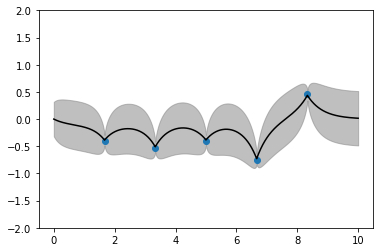

In [167]:
plt.plot(t_grid, m[:, 0], color='k')
plt.fill_between(t_grid,
                 m[:, 0] - S[:, 0, 0] ** 0.5,
                 m[:, 0] + S[:, 0, 0] ** 0.5,
                 color='gray',
                 alpha=0.5)
plt.scatter(t_train, x_train)
plt.ylim([-2, 2])
plt.show()